#4.4 Tutorial: Optimizations for Deep Neural Networks

This tutorial provides hands-on coding experience to implement multiple optimizers for your deep neural network. You will start by exploring the vanishing and exploding gradient problems and some of their most popular solutions. Next, you will inspect how batch normalization can help stabilize the parameters during training. Then, you will see when transfer learning and pretrained layers can help you tackle complex tasks even when you have little training data. Finally, you will try to run several fast optimizers for large neural networks such as momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, Adam, and Nadam optimization.

_This notebook contains all the sample code for chapter on optimizing neural nets.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
#assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
#assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
%tensorflow_version 2.x
print(tf.__version__)
#assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


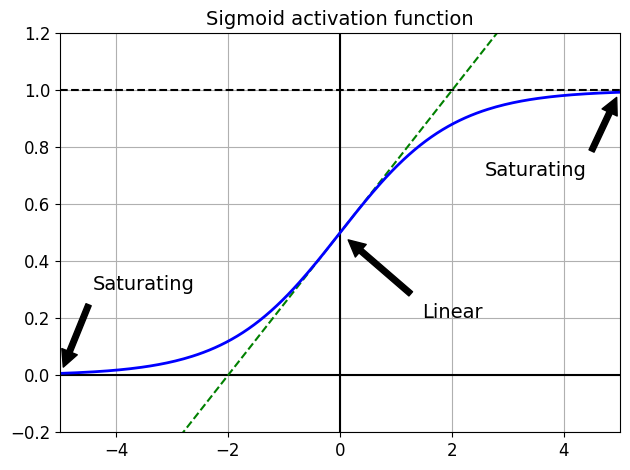

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


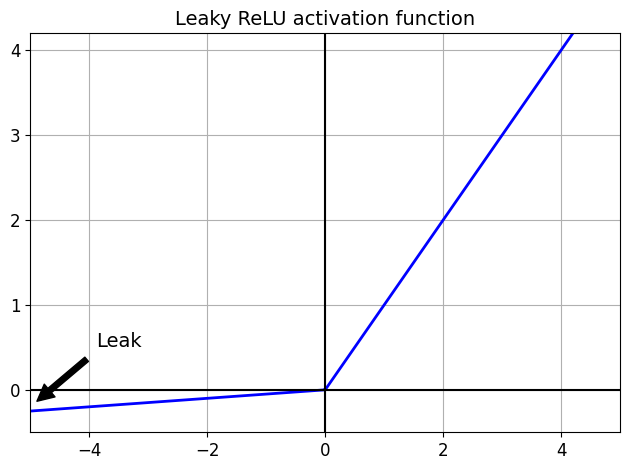

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [19]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-4),
              metrics=["accuracy"])

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10, # Number of epochs with no improvement after which training will be stopped
    mode = 'max', # Stops training when the quantity monitored has stopped increasing
    restore_best_weights = True # Restores model weights from the epoch with the highest value of the monitored quantity
)

In [32]:
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid), callbacks = [early_stopping])

Epoch 1/1000
1719/1719 [==============================] - 10s 5ms/step - loss: 0.1452 - accuracy: 0.9458 - val_loss: 0.3079 - val_accuracy: 0.9032
Epoch 2/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1363 - accuracy: 0.9499 - val_loss: 0.3137 - val_accuracy: 0.9042
Epoch 3/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1325 - accuracy: 0.9514 - val_loss: 0.3235 - val_accuracy: 0.8984
Epoch 4/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1296 - accuracy: 0.9521 - val_loss: 0.3179 - val_accuracy: 0.9008
Epoch 5/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1283 - accuracy: 0.9525 - val_loss: 0.3202 - val_accuracy: 0.8986
Epoch 6/1000
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1259 - accuracy: 0.9541 - val_loss: 0.3286 - val_accuracy: 0.9030
Epoch 7/1000
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1243 - accuracy: 0.9545 - val_loss: 0.3303 

Maximum Validation Accuracy: 90.42%


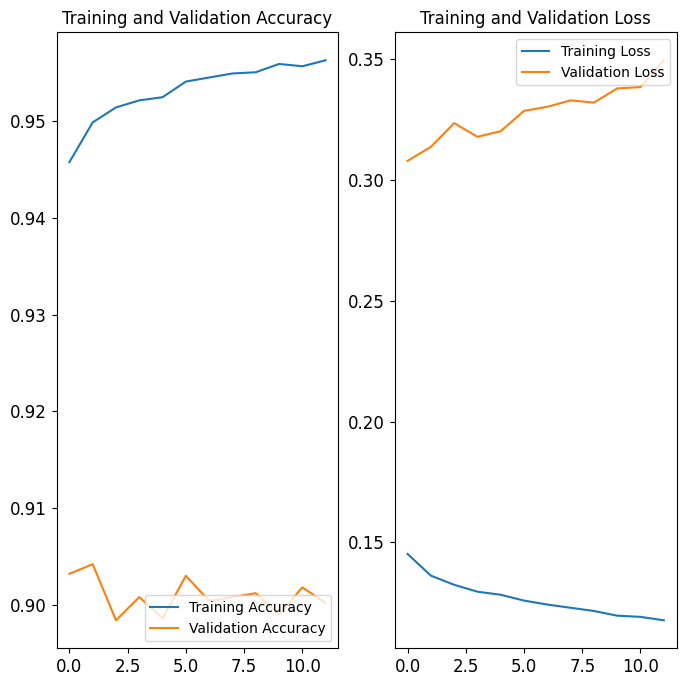

In [33]:
val_accuracy_history = history.history['val_accuracy']
max_val_accuracy = max(val_accuracy_history)
print(f"Maximum Validation Accuracy: {max_val_accuracy*100:.2f}%")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.history['loss'])
epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid), callbacks = [early_stopping])

Epoch 1/1000
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1193 - accuracy: 0.9568 - val_loss: 0.3204 - val_accuracy: 0.9022
Epoch 2/1000
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1101 - accuracy: 0.9606 - val_loss: 0.3265 - val_accuracy: 0.9072
Epoch 3/1000
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1063 - accuracy: 0.9615 - val_loss: 0.3281 - val_accuracy: 0.9020
Epoch 4/1000
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1033 - accuracy: 0.9629 - val_loss: 0.3276 - val_accuracy: 0.9012
Epoch 5/1000
1719/1719 [==============================] - 11s 7ms/step - loss: 0.1011 - accuracy: 0.9636 - val_loss: 0.3342 - val_accuracy: 0.9026
Epoch 6/1000
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0986 - accuracy: 0.9648 - val_loss: 0.3434 - val_accuracy: 0.9036
Epoch 7/1000
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0964 - accuracy: 0.9655 - val_loss: 0

Maximum Validation Accuracy: 90.72%


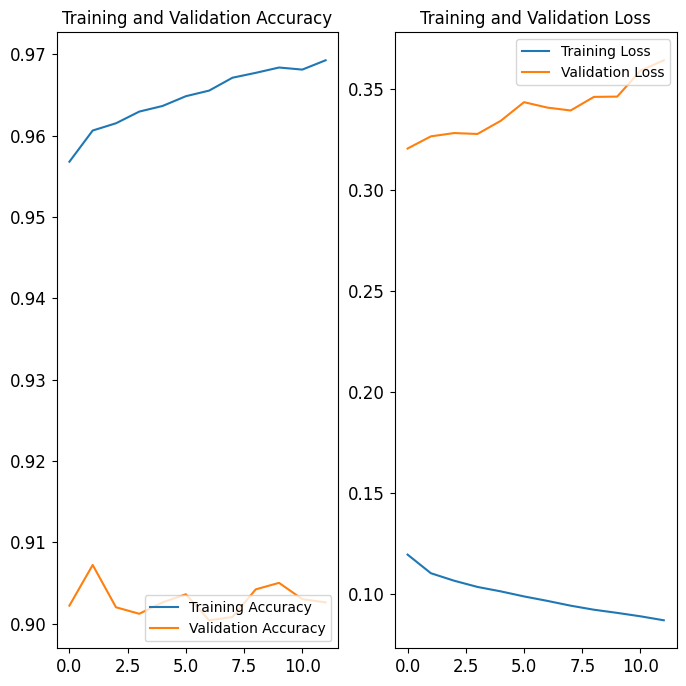

In [41]:
val_accuracy_history = history.history['val_accuracy']
max_val_accuracy = max(val_accuracy_history)
print(f"Maximum Validation Accuracy: {max_val_accuracy*100:.2f}%")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = len(history.history['loss'])
epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6860 - accuracy: 0.7701 - val_loss: 0.5085 - val_accuracy: 0.8314
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4809 - accuracy: 0.8313 - val_loss: 0.4298 - val_accuracy: 0.8532
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4349 - accuracy: 0.8468 - val_loss: 0.5339 - val_accuracy: 0.8048
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4078 - accuracy: 0.8576 - val_loss: 0.3904 - val_accuracy: 0.8660
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3890 - accuracy: 0.8638 - val_loss: 0.3704 - val_accuracy: 0.8700
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3706 - accuracy: 0.8701 - val_loss: 0.3679 - val_accuracy: 0.8760
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3583 - accuracy: 0.8730 - val_loss: 0.3638 - val_accuracy

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


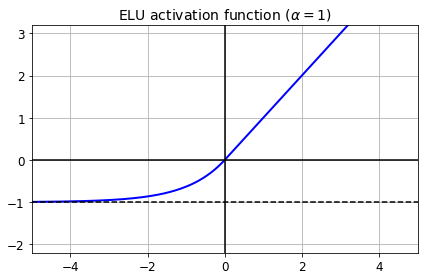

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [19]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [20]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
print(alpha_0_1)
print(scale_0_1)

1.6732632423543778
1.0507009873554805


In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


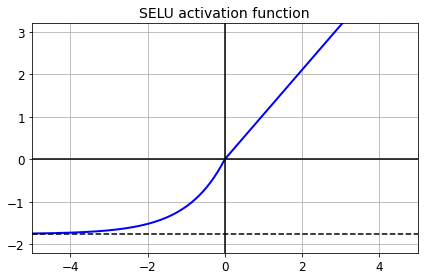

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [22]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [23]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [27]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 46s 22ms/step - loss: 2.3586 - accuracy: 0.1022 - val_loss: 2.3402 - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 37s 22ms/step - loss: 1.7077 - accuracy: 0.3050 - val_loss: 1.4648 - val_accuracy: 0.3642
Epoch 3/5
1719/1719 [==============================] - 37s 21ms/step - loss: 1.5518 - accuracy: 0.3455 - val_loss: 1.3268 - val_accuracy: 0.4490
Epoch 4/5
1719/1719 [==============================] - 36s 21ms/step - loss: 1.3713 - accuracy: 0.4219 - val_loss: 1.2096 - val_accuracy: 0.5056
Epoch 5/5
1719/1719 [==============================] - 36s 21ms/step - loss: 1.2990 - accuracy: 0.4728 - val_loss: 1.3111 - val_accuracy: 0.4570


Now look at what happens if we try to use the ReLU activation function instead:

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 44s 21ms/step - loss: 2.1720 - accuracy: 0.1511 - val_loss: 1.9105 - val_accuracy: 0.1984
Epoch 2/5
1719/1719 [==============================] - 35s 20ms/step - loss: 1.6818 - accuracy: 0.2576 - val_loss: 1.3485 - val_accuracy: 0.3488
Epoch 3/5
1719/1719 [==============================] - 35s 20ms/step - loss: 1.4178 - accuracy: 0.3790 - val_loss: 1.8466 - val_accuracy: 0.2828
Epoch 4/5
1719/1719 [==============================] - 34s 20ms/step - loss: 1.0921 - accuracy: 0.4965 - val_loss: 0.9495 - val_accuracy: 0.5536
Epoch 5/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.9689 - accuracy: 0.5755 - val_loss: 0.7692 - val_accuracy: 0.7238


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [33]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

In [35]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [37]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5322 - accuracy: 0.8152 - val_loss: 0.3840 - val_accuracy: 0.8660
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3927 - accuracy: 0.8603 - val_loss: 0.3447 - val_accuracy: 0.8752
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3573 - accuracy: 0.8708 - val_loss: 0.3399 - val_accuracy: 0.8750
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3264 - accuracy: 0.8825 - val_loss: 0.3230 - val_accuracy: 0.8840
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3048 - accuracy: 0.8893 - val_loss: 0.3128 - val_accuracy: 0.8890
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2881 - accuracy: 0.8946 - val_loss: 0.3130 - val_accuracy: 0.8874
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2747 - accuracy: 0.9003 - val_loss: 0.3058 - val_ac

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [38]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5348 - accuracy: 0.8127 - val_loss: 0.3871 - val_accuracy: 0.8628
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3939 - accuracy: 0.8574 - val_loss: 0.3470 - val_accuracy: 0.8802
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3554 - accuracy: 0.8729 - val_loss: 0.3421 - val_accuracy: 0.8782
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3248 - accuracy: 0.8815 - val_loss: 0.3241 - val_accuracy: 0.8822
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3058 - accuracy: 0.8894 - val_loss: 0.3143 - val_accuracy: 0.8898
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2885 - accuracy: 0.8949 - val_loss: 0.3186 - val_accuracy: 0.8848
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2755 - accuracy: 0.8999 - val_loss: 0.3158 - val_ac

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [42]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Faster Optimizers

## Momentum optimization

In [43]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [44]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [45]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [46]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [47]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [48]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [49]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [54]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [55]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [56]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4831 - accuracy: 0.8310 - val_loss: 0.4001 - val_accuracy: 0.8622
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3761 - accuracy: 0.8661 - val_loss: 0.3695 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3437 - accuracy: 0.8773 - val_loss: 0.3724 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3232 - accuracy: 0.8845 - val_loss: 0.3486 - val_accuracy: 0.8782
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3082 - accuracy: 0.8899 - val_loss: 0.3432 - val_accuracy: 0.8758
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - accuracy: 0.8949 - val_loss: 0.3419 - val_accuracy: 0.8780
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2852 - accuracy: 0.8978 - val_loss: 0.3364 - val_accuracy:

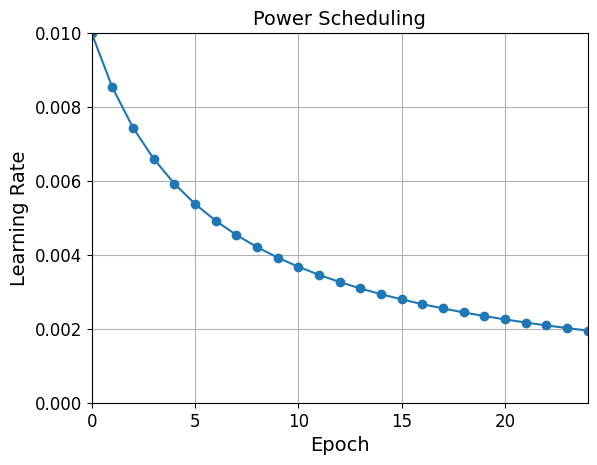

In [57]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [58]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [59]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [60]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [61]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 23s 11ms/step - loss: 0.7475 - accuracy: 0.7773 - val_loss: 0.7344 - val_accuracy: 0.7874 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7028 - accuracy: 0.7895 - val_loss: 0.7931 - val_accuracy: 0.7484 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6696 - accuracy: 0.7969 - val_loss: 0.9201 - val_accuracy: 0.7594 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6252 - accuracy: 0.8129 - val_loss: 0.5326 - val_accuracy: 0.8342 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5045 - accuracy: 0.8425 - val_loss: 0.5245 - val_accuracy: 0.8422 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4915 - accuracy: 0.8477 - val_loss: 0.4987 - val_accuracy: 0.8488 - lr: 0.0056
Epoch 7/25
1719/1719 [=============================

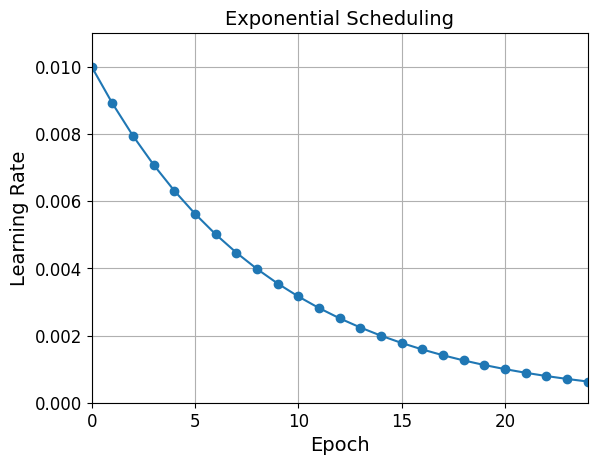

In [62]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [63]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [64]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4738 - accuracy: 0.8355 - val_loss: 0.3771 - val_accuracy: 0.8652 - lr: 8.9124e-04
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3399 - accuracy: 0.8764 - val_loss: 0.3593 - val_accuracy: 0.8728 - lr: 7.9430e-04
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2925 - accuracy: 0.8910 - val_loss: 0.3323 - val_accuracy: 0.8828 - lr: 7.0791e-04
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2588 - accuracy: 0.9038 - val_loss: 0.3255 - val_accuracy: 0.8840 - lr: 6.3092e-04
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2294 - accuracy: 0.9143 - val_loss: 0.3159 - val_accuracy: 0.8906 - lr: 5.6229e-04
Epoch 6/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2032 - accuracy: 0.9240 - val_loss: 0.3215 - val_accuracy: 0.8910 - lr: 5.0114e-04
Epoch 7/25
1719/1719 [======

In [65]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

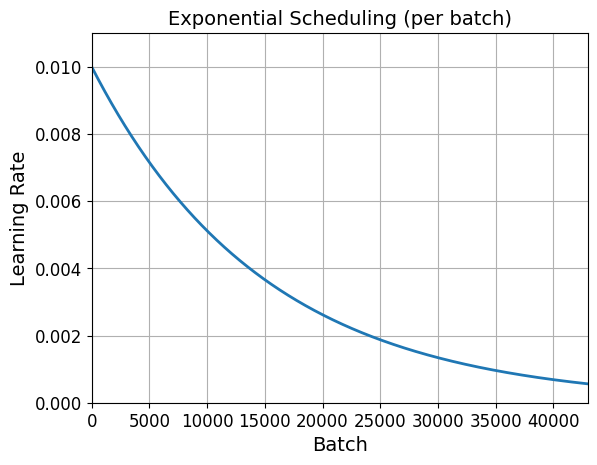

In [66]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [67]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [68]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [69]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.7445 - accuracy: 0.7787 - val_loss: 0.7143 - val_accuracy: 0.7990 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6799 - accuracy: 0.7945 - val_loss: 0.6371 - val_accuracy: 0.8102 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8263 - accuracy: 0.7634 - val_loss: 1.0825 - val_accuracy: 0.6784 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7859 - accuracy: 0.7711 - val_loss: 0.8583 - val_accuracy: 0.7622 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8323 - accuracy: 0.7594 - val_loss: 0.7299 - val_accuracy: 0.7816 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5301 - accuracy: 0.8229 - val_loss: 0.5777 - val_accuracy: 0.8280 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

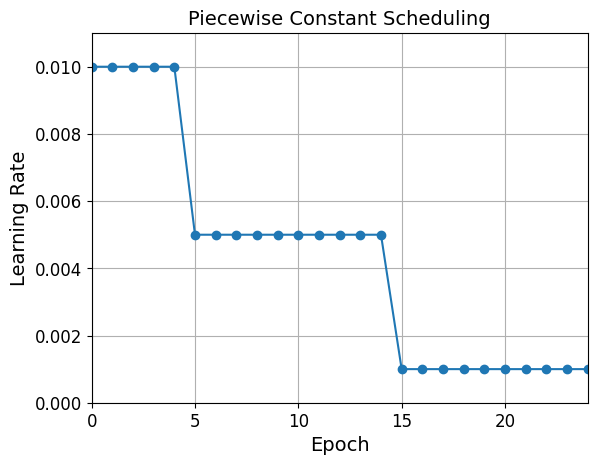

In [70]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [71]:
tf.random.set_seed(42)
np.random.seed(42)

In [72]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4796 - accuracy: 0.8307 - val_loss: 0.3873 - val_accuracy: 0.8620 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3653 - accuracy: 0.8676 - val_loss: 0.3849 - val_accuracy: 0.8666 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3290 - accuracy: 0.8791 - val_loss: 0.3386 - val_accuracy: 0.8760 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3026 - accuracy: 0.8897 - val_loss: 0.3492 - val_accuracy: 0.8790 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2818 - accuracy: 0.8969 - val_loss: 0.3302 - val_accuracy: 0.8826 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2671 - accuracy: 0.9018 - val_loss: 0.3683 - val_accuracy: 0.8790 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================]

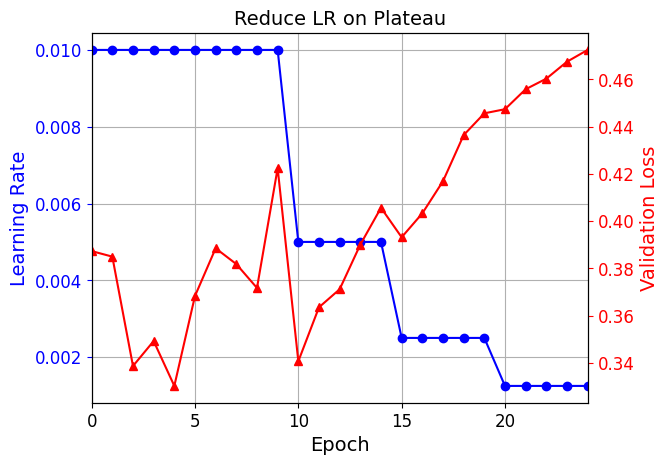

In [73]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4873 - accuracy: 0.8293 - val_loss: 0.4018 - val_accuracy: 0.8602
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3791 - accuracy: 0.8655 - val_loss: 0.3693 - val_accuracy: 0.8736
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3454 - accuracy: 0.8769 - val_loss: 0.3705 - val_accuracy: 0.8710
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3236 - accuracy: 0.8847 - val_loss: 0.3480 - val_accuracy: 0.8756
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3077 - accuracy: 0.8907 - val_loss: 0.3426 - val_accuracy: 0.8776
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2936 - accuracy: 0.8959 - val_loss: 0.3402 - val_accuracy: 0.8806
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2831 - accuracy: 0.8996 - val_loss: 0.3347 - val_accurac

For piecewise constant scheduling, try this:

In [75]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [76]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 4s 9ms/step - loss: nan - accuracy: 0.3695


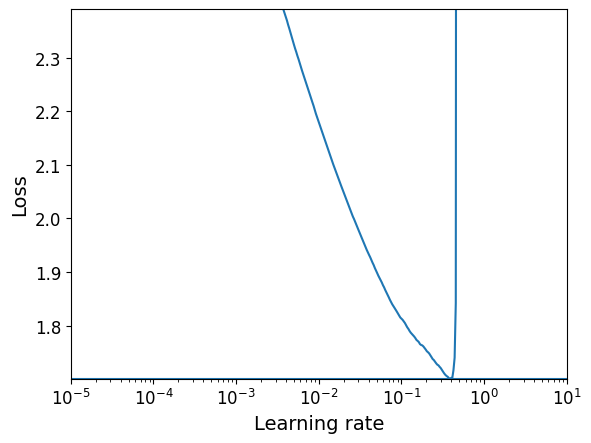

In [78]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [79]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (iter2 - self.iteration)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [80]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 4s 10ms/step - loss: 0.5003 - accuracy: 0.8243 - val_loss: 0.4009 - val_accuracy: 0.8626
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3772 - accuracy: 0.8655 - val_loss: 0.3714 - val_accuracy: 0.8730
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3413 - accuracy: 0.8780 - val_loss: 0.3689 - val_accuracy: 0.8730
Epoch 4/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3160 - accuracy: 0.8873 - val_loss: 0.3499 - val_accuracy: 0.8776
Epoch 5/25
430/430 [==============================] - 5s 11ms/step - loss: 0.2991 - accuracy: 0.8937 - val_loss: 0.3412 - val_accuracy: 0.8804
Epoch 6/25
430/430 [==============================] - 4s 8ms/step - loss: 0.2835 - accuracy: 0.8990 - val_loss: 0.3440 - val_accuracy: 0.8822
Epoch 7/25
430/430 [==============================] - 4s 8ms/step - loss: 0.2722 - accuracy: 0.9036 - val_loss: 0.3368 - val_accuracy: 0.8846
Epoc

# Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [81]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [82]:
X_train_A.shape

(43986, 28, 28)

In [83]:
X_train_B.shape

(200, 28, 28)

In [84]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [85]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [86]:
tf.random.set_seed(42)
np.random.seed(42)

In [87]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [88]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [89]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.3642 - accuracy: 0.8724 - val_loss: 0.2899 - val_accuracy: 0.9008
Epoch 2/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2667 - accuracy: 0.9072 - val_loss: 0.2629 - val_accuracy: 0.9033
Epoch 3/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2453 - accuracy: 0.9134 - val_loss: 0.2398 - val_accuracy: 0.9131
Epoch 4/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2298 - accuracy: 0.9189 - val_loss: 0.2400 - val_accuracy: 0.9136
Epoch 5/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2174 - accuracy: 0.9232 - val_loss: 0.2549 - val_accuracy: 0.9096
Epoch 6/20
1375/1375 [==============================] - 8s 6ms/step - loss: 0.2088 - accuracy: 0.9257 - val_loss: 0.2277 - val_accuracy: 0.9178
Epoch 7/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2002 - accuracy: 0.9289 - val_loss: 0.2439 - val_accuracy:

In [90]:
model_A.save("my_model_A.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [92]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [93]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 84ms/step - loss: 0.4312 - accuracy: 0.8250 - val_loss: 0.2125 - val_accuracy: 0.9574
Epoch 2/20
7/7 [==============================] - 0s 36ms/step - loss: 0.1317 - accuracy: 0.9950 - val_loss: 0.1270 - val_accuracy: 0.9807
Epoch 3/20
7/7 [==============================] - 0s 38ms/step - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.9807
Epoch 4/20
7/7 [==============================] - 0s 38ms/step - loss: 0.0556 - accuracy: 1.0000 - val_loss: 0.0805 - val_accuracy: 0.9838
Epoch 5/20
7/7 [==============================] - 0s 38ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.0703 - val_accuracy: 0.9848
Epoch 6/20
7/7 [==============================] - 0s 38ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9848
Epoch 7/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.0625 - val_accuracy: 0.9838
Epoch 8/20
7/7 [===========

In [94]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_236 (Dense)           (None, 300)               235500    
                                                                 
 dense_237 (Dense)           (None, 100)               30100     
                                                                 
 dense_238 (Dense)           (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [96]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [97]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [98]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 50ms/step - loss: 0.5078 - accuracy: 0.7350 - val_loss: 0.3342 - val_accuracy: 0.8570
Epoch 2/4
7/7 [==============================] - 0s 31ms/step - loss: 0.2734 - accuracy: 0.9050 - val_loss: 0.2198 - val_accuracy: 0.9260
Epoch 3/4
7/7 [==============================] - 0s 23ms/step - loss: 0.1807 - accuracy: 0.9600 - val_loss: 0.1645 - val_accuracy: 0.9503
Epoch 4/4
7/7 [==============================] - 0s 33ms/step - loss: 0.1347 - accuracy: 0.9700 - val_loss: 0.1377 - val_accuracy: 0.9615


Epoch 1/16
7/7 [==============================] - 1s 66ms/step - loss: 0.0860 - accuracy: 0.9750 - val_loss: 0.0666 - val_accuracy: 0.9848
Epoch 2/16
7/7 [==============================] - 0s 33ms/step - loss: 0.0432 - accuracy: 0.9950 - val_loss: 0.0485 - val_accuracy: 0.9909
Epoch 3/16
7/7 [==============================] - 0s 35ms/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9929
Epoch 4/16
7/7 [==============================] - 0s 33ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 0.9929
Epoch 5/16
7/7 [==============================] - 0s 32ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9939
Epoch 6/16
7/7 [==============================] - 0s 22ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 0.9959
Epoch 7/16
7/7 [==============================] - 0s 33ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9959
Epoch 8/16
7/7 [===========

So, what's the final verdict?

In [99]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.0317 - accuracy: 0.9920


[0.03173137456178665, 0.9919999837875366]

In [100]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9965


[0.013333138078451157, 0.9965000152587891]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [101]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337